##  1) Preparación del entorno y dependencias

En un estudio reproducible de procesamiento de lenguaje natural (PLN), la primera etapa consiste en preparar un **entorno controlado** que garantice la estabilidad de los experimentos.

Este paso es crucial porque:
- **Reproducibilidad:** fijar versiones asegura que los resultados obtenidos puedan replicarse en diferentes equipos y fechas.  
- **Eficiencia:** se instalan solo las librerías necesarias y en las versiones exactas que evitan incompatibilidades.  
- **Cobertura de necesidades:** el análisis exploratorio, el preprocesamiento, el entrenamiento de modelos y la evaluación requieren paquetes tanto del ecosistema científico de Python como de bibliotecas especializadas en NLP.

En este proyecto se trabajan tres componentes principales:

1. **Núcleo científico**  
   - `numpy`, `pandas`, `scikit-learn`, `matplotlib`: soporte para manipulación de datos, métricas de clasificación y visualización de resultados (matriz de confusión, distribuciones, etc.).

2. **Transformers y ecosistema NLP**  
   - `transformers`, `datasets`, `evaluate`, `accelerate`: base para cargar modelos preentrenados (como BETO o RoBERTuito), manipular el corpus EmoEvent y calcular métricas de manera eficiente en GPU/CPU.
   - `sentencepiece`: necesario para tokenizadores modernos.

3. **Procesamiento lingüístico en español**  
   - `spaCy` con el modelo `es_core_news_md`: utilizado en tareas exploratorias (lemmatización, análisis gramatical, detección de entidades), lo cual enriquece la fase de análisis exploratorio de datos (EDA).

---

###  Metodología aplicada en esta celda

- Se define la función `ensure()` que revisa si un paquete ya está instalado; si no, lo instala con `pip`.  
- Se instalan las dependencias en versiones estables y compatibles con **Python 3.12** (entorno actual de Google Colab).  
- Se descarga automáticamente el modelo de spaCy en español si no está presente.

Con esto dejamos preparado el entorno para las siguientes fases:
- **EDA del dataset EmoEvent.**
- **Entrenamiento y evaluación** de los tres modelos propuestos.
- **Reporte de métricas** por clase y por evento, además de matrices de confusión.

---

In [10]:
# ---------- 1) Dependencias seguras (instala solo si faltan) ----------

import sys, subprocess, importlib

# Función auxiliar: revisa si el paquete existe; si no, lo instala
def ensure(pkg_spec):
    try:
        importlib.import_module(pkg_spec.split("==")[0])
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg_spec])

# --- Núcleo científico (versiones estables y compatibles con Python 3.12) ---
for p in ["numpy==1.26.4", "pandas==2.2.2", "scikit-learn==1.4.2", "matplotlib==3.8.4"]:
    ensure(p)

# --- Ecosistema NLP / Transformers ---
for p in ["spacy==3.7.5", "sentencepiece", "transformers==4.47.1", "datasets", "evaluate", "accelerate"]:
    ensure(p)

# --- Modelo spaCy para español (descarga si no está instalado localmente) ---
import spacy, importlib
try:
    _ = spacy.load("es_core_news_md")
except Exception:
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "es_core_news_md"])

##  2) Imports, configuración y utilitarios

Este paso establece la **configuración base del experimento** y define funciones de **apoyo a la evaluación**. Su objetivo es garantizar **estabilidad**, **trazabilidad** y **mediciones comparables** entre modelos.

### Objetivos de este bloque
- **Cargar librerías** de manipulación de datos y visualización: `numpy`, `pandas`, `matplotlib`.
- **Fijar la semilla** de aleatoriedad (`SEED=42`) para reducir la varianza entre corridas (reproducibilidad).
- **Silenciar advertencias** no críticas para mantener el notebook legible.
- **Desactivar el paralelismo de tokenizers** (`TOKENIZERS_PARALLELISM=false`) y evitar *warnings*/condiciones de carrera durante la tokenización masiva.
- **Definir un utilitario de evaluación por evento** que complemente las métricas globales por clase.

### Diseño de la función `per_event_table(...)`
La evaluación por **evento** es central en EmoEvent porque los tweets están asociados a situaciones/temas concretos. Reportar solo métricas globales puede ocultar disparidades de desempeño entre eventos.

- **Entradas**
  - `df_test`: DataFrame con la columna `event` (más metadatos opcionales).
  - `y_true`, `y_pred`: arreglos/series con etiquetas verdaderas y predichas (mismo espacio de etiquetas).
  - `labels`: lista **ordenada** de etiquetas canónicas (asegura consistencia en `classification_report`).
  - `min_support`: mínimo de muestras por evento para ser considerado (por defecto, 5) y evitar varianza extrema.

- **Salidas**
  - Un `DataFrame` con filas por evento y las columnas:  
    - `event`: identificador del evento.  
    - `support`: tamaño de muestra del evento en el split.  
    - `f1_macro`: F1 macro **dentro del evento** (promedia clases presentes, útil en desbalance).  
    - `accuracy`: exactitud por evento (proporción de aciertos, robusto y fácil de interpretar).

- **Criterio de ordenamiento**
  - Ordena por `f1_macro` (desc) y `support` (desc) para priorizar eventos donde el modelo logra buen equilibrio entre clases y posee evidencia suficiente.

#### Justificación metodológica
- **F1 macro** por evento mide el equilibrio del modelo entre clases dentro de un contexto temático, mitigando el sesgo de clases dominantes.  
- **Accuracy** por evento facilita detectar eventos “difíciles” en términos de acierto global.  
- **Filtrado por `min_support`** evita conclusiones a partir de muestras demasiado pequeñas.

> Estas tablas complementarán las métricas agregadas por clase (precision/recall/F1) y la **matriz de confusión**, ayudando a identificar **eventos** donde un modelo se desempeña especialmente bien o mal (hipótesis para análisis de error).

---

In [11]:

# ---------- 2) Imports, configuración y utilitarios ----------
import os, re, random, warnings
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from IPython.display import display

warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

SEED = 42
random.seed(SEED); np.random.seed(SEED)

# Tabla por evento (accuracy robusto)
from sklearn.metrics import classification_report as sk_clf_report

def per_event_table(df_test, y_true, y_pred, labels, min_support=5):
    tmp = df_test[["event"]].copy()
    tmp["true"] = y_true
    tmp["pred"] = y_pred

    rows = []
    for ev, g in tmp.groupby("event"):
        if len(g) < min_support:
            continue
        rep = sk_clf_report(
            g["true"], g["pred"], labels=labels,
            output_dict=True, zero_division=0
        )
        rows.append({
            "event": ev,
            "support": len(g),
            "f1_macro": rep.get("macro avg", {}).get("f1-score", np.nan),
            "accuracy": (g["true"].to_numpy() == g["pred"].to_numpy()).mean()
        })

    return pd.DataFrame(rows).sort_values(
        ["f1_macro","support"], ascending=[False, False]
    )

##  3) Carga de datos y normalización

**Propósito.**  
Estandarizar la lectura y el esquema de columnas de los *splits* `train/dev/test` del dataset **EmoEvent**, garantizando que el resto del pipeline trabaje sobre una **estructura unificada**. Además, se construye la etiqueta final de **8 clases** (`label8`) combinando la emoción con la dimensión ofensiva.

### Fuentes y formato
- Archivos TSV (tab-separated) provistos por el *benchmark* EmoEvent: `train.tsv`, `dev.tsv`, `test.tsv`.
- Codificación: se intenta primero **UTF-8** y, si falla, se recurre a **latin-1** para robustez.

### Normalización de columnas
Los archivos pueden llegar con nombres de columnas heterogéneos (p. ej., `text`, `contenido`, `label`, `off`, `evento`).  
Para evitar dependencias frágiles:
- Se **mapean** nombres comunes a un **esquema estándar**:
  - `tweet`  ← (`tweet`, `text`, `contenido`, `content`)
  - `emotion` ← (`emotion`, `label`, `emotions`, `etiqueta`)
  - `offensive` ← (`offensive`, `off`, `is_offensive`, `ofensivo`, `off_label`)
  - `event` ← (`event`, `evento`, `topic`)
- Se **verifica** la presencia mínima de `tweet` y `emotion`.  
- Si faltan, se **crean por defecto**:
  - `offensive` = `"NO"` (no ofensivo)  
  - `event` = `"NA"` (evento desconocido)
- Se **tipifican** las columnas clave como `str` para evitar problemas aguas abajo.

### Construcción de la etiqueta `label8`
El benchmark considera **8 clases**: `anger`, `sadness`, `joy`, `disgust`, `fear`, `surprise`, `offensive`, `other`.  
Para mantener la comparabilidad con trabajos previos:
- Si `offensive` ≠ `"NO"` → `label8 = "offensive"`  
- En caso contrario → `label8 = emotion`  
Esto prioriza la detección de ofensividad sobre la emoción declarada, como es usual en EmoEvent.

### Salidas y chequeos
- DataFrames `train`, `dev`, `test` con columnas estandarizadas y la nueva `label8`.
- Se imprime el tamaño de cada *split* y se muestra una vista (`head(3)`) para verificación rápida.

> Esta etapa asegura que **todas las funciones subsecuentes** (tokenización, *fine-tuning*, evaluación por clase y por evento) operen sobre un **esquema consistente**, minimizando fallos por discrepancias de origen.

In [12]:
# ---------- 3) Carga de datos y normalización ----------
PATH_TRAIN = "/content/train.tsv"
PATH_DEV   = "/content/dev.tsv"
PATH_TEST  = "/content/test.tsv"

def read_tsv(path):
    try:    return pd.read_csv(path, sep="\t", encoding="utf-8")
    except: return pd.read_csv(path, sep="\t", encoding="latin-1")

def normalize_columns(df):
    cols = {c.lower().strip(): c for c in df.columns}
    def find(cands):
        for c in cands:
            if c in cols: return cols[c]
        return None
    ren = {}
    m = {
        "tweet":  ["tweet","text","contenido","content"],
        "emotion":["emotion","label","emotions","etiqueta"],
        "offensive":["offensive","off","is_offensive","ofensivo","off_label"],
        "event":  ["event","evento","topic"],
    }
    for std, cands in m.items():
        f = find(cands)
        if f and f != std: ren[f] = std
    df = df.rename(columns=ren)
    assert {"tweet","emotion"}.issubset(df.columns), f"Faltan columnas requeridas en {list(df.columns)}"
    if "offensive" not in df.columns: df["offensive"] = "NO"
    if "event" not in df.columns:     df["event"] = "NA"
    for c in ["tweet","emotion","offensive","event"]:
        df[c] = df[c].astype(str)
    return df

train = normalize_columns(read_tsv(PATH_TRAIN)).assign(split="train")
dev   = normalize_columns(read_tsv(PATH_DEV)).assign(split="dev")
test  = normalize_columns(read_tsv(PATH_TEST)).assign(split="test")

def to_label8(off, emo):
    return "offensive" if str(off).strip().upper()!="NO" else emo

for df in (train, dev, test):
    df["label8"] = [to_label8(o,e) for o,e in zip(df["offensive"], df["emotion"])]

print({"train": len(train), "dev": len(dev), "test": len(test)})
display(train.head(3))

{'train': 5723, 'dev': 844, 'test': 1656}


,id,event,tweet,offensive,emotion,split,label8
0,a0c1a858-a9b8-4cb1-8a81-1602736ff5b8,GameOfThrones,La Gran Guerra de #JuegoDeTronos nos ha dejado...,NO,others,train,others
1,9b272817-a231-4f68-bdf4-3350d4919330,Venezuela,El golpe de Estado en #Venezuela está más lejo...,NO,others,train,others
2,4bd5b1e5-4b74-440a-82f4-c2567a241011,NotreDame,No tengo una foto en la catedral de #NotreDame...,NO,sadness,train,sadness


##  4) Limpieza ligera de tweets

**Propósito.**  
Antes de entrenar modelos de clasificación de emociones es necesario aplicar un **preprocesamiento mínimo** que elimine ruido evidente en los tweets, sin alterar en exceso su estructura original (ya que las señales lingüísticas son importantes para modelos de lenguaje).

### Estrategia aplicada
Se implementa una función `clean_tweet()` con reglas basadas en expresiones regulares para limpiar el texto:

1. **URLs**  
   - Expresión: `https?://\S+|www\.\S+`  
   - Motivo: los enlaces no aportan contenido emocional y añaden ruido.

2. **Menciones a usuarios (@usuario)**  
   - Expresión: `@\w+`  
   - Motivo: los *handles* de Twitter no son informativos para la tarea de clasificación.

3. **Repeticiones excesivas de caracteres**  
   - Expresión: `(.)\1{2,}` reemplazado por `\1\1`  
   - Motivo: suaviza secuencias de 3 o más caracteres repetidos (ej. `"soooorry"` → `"soorry"`) manteniendo cierta intensidad emocional pero evitando tokens artificiales.

4. **Espacios múltiples**  
   - Expresión: `\s+` → `' '`  
   - Motivo: homogeneizar el espaciado tras las sustituciones previas.

### Resultados
- Se genera una nueva columna `text_clean` en cada split (`train`, `dev`, `test`).  
- Esta columna conserva el contenido esencial del tweet pero en formato **más normalizado**, reduciendo el ruido para los modelos.

> Esta limpieza es **ligera**: no se eliminan emojis, signos de exclamación ni mayúsculas, ya que pueden ser indicativos de emoción y son útiles en clasificación afectiva.

In [13]:
# ---------- 4 ) Limpieza ligera de tweets ----------

# Expresiones regulares para identificar patrones a limpiar
URL_RE   = re.compile(r'https?://\S+|www\.\S+', re.IGNORECASE)  # URLs
MENT_RE  = re.compile(r'@\w+')                                 # menciones @usuario
SPACE_RE = re.compile(r'\s+')                                  # espacios múltiples
REPEAT_RE= re.compile(r'(.)\1{2,}', flags=re.UNICODE)          # repeticiones de 3+ chars → 2

def clean_tweet(text: str) -> str:
    text = re.sub(URL_RE, ' ', str(text))      # elimina URLs
    text = re.sub(MENT_RE, ' ', text)          # elimina menciones
    text = REPEAT_RE.sub(r'\1\1', text)        # suaviza repeticiones excesivas
    text = SPACE_RE.sub(' ', text).strip()     # normaliza espacios
    return text

# Aplica la limpieza a cada split y guarda en nueva columna
for df in (train, dev, test):
    df["text_clean"] = df["tweet"].map(clean_tweet)

##  5) MODELO 1 — TF-IDF (palabra + carácter) + Regresión Logística Multiclase

**Objetivo.**  
Establecer un **baseline fuerte y explicable** para la tarea de clasificación de emociones usando representaciones TF-IDF y un clasificador lineal multiclase. Este enfoque es rápido, robusto frente a vocabularios ruidosos (como en Twitter) y entrega métricas competitivas como punto de partida para comparar con modelos neuronales.

### Diseño de atributos (featurización)

- **TF-IDF de palabra (1–2-gramas)**  
  - Captura **unigramas** (términos) y **bigramas** (co-ocurrencias locales) que suelen ser clave para emociones (e.g., “muy feliz”, “qué rabia”).  
  - `strip_accents="unicode"` y `lowercase=True` homogenizan variantes ortográficas.  
  - `sublinear_tf=True` mitiga la influencia de repeticiones excesivas.  
  - `token_pattern` permite incluir **hashtags** explícitos (`#[\w\-]+`) que funcionan como marcadores semánticos.

- **TF-IDF de carácter (4–5-gramas)**  
  - Robusto ante **ruido** (typos, elongaciones: “buenoooo”) y variantes morfológicas.  
  - Captura sufijos/prefijos y formas informales frecuentes en redes.

- **Combinación con `ColumnTransformer`**  
  - Se integran ambos espacios (`palabra`, `carácter`) con pesos relativos (`w: 1.0`, `c: 0.4`).  
  - Razonamiento: el espacio de palabra domina, y el canal de carácter actúa como **apoyo** para robustez.

### Clasificador

- **Regresión Logística Multinomial** (`solver="saga"`, `multi_class="multinomial"`)  
  - Adecuada para varias clases (`8` emociones) y eficiente con espacios de alta dimensión.  
  - `class_weight="balanced"` (vía vector precomputado) compensa **desbalance** entre emociones.  
  - `C=3.0` (regularización moderada) y `max_iter=3000` aseguran convergencia en un espacio grande.

### Evaluación

1. **Reporte por clase** (precision/recall/F1/soporte) con `classification_report`.  
2. **Matriz de confusión** (interpretación de confusiones entre emociones).  
3. **Análisis por evento** usando `per_event_table(...)`: F1 macro y accuracy por tópico/evento con filtro de soporte mínimo.

> Este baseline entrega una línea base clara para contrastar con los modelos de *fine-tuning* (p.ej., BETO/RoBERTuito) y, si se incluye, con un modelo neuronal propio (RNN/CNN). La combinación palabra+carácter suele mejorar frente a usar solo palabra en dominios ruidosos como Twitter.


== Modelo 1 — DEV (8 clases) ==


,precision,recall,f1-score,support
anger,0.214286,0.409091,0.281250,44.000000
disgust,0.000000,0.000000,0.000000,5.000000
fear,0.101695,0.857143,0.181818,7.000000
joy,0.542373,0.551724,0.547009,174.000000
offensive,0.600000,0.552632,0.575342,76.000000
others,0.756667,0.561881,0.644886,404.000000
sadness,0.647619,0.653846,0.650718,104.000000
surprise,0.163265,0.266667,0.202532,30.000000
accuracy,0.550948,0.550948,0.550948,0.550948
macro avg,0.378238,0.481623,0.385444,844.000000


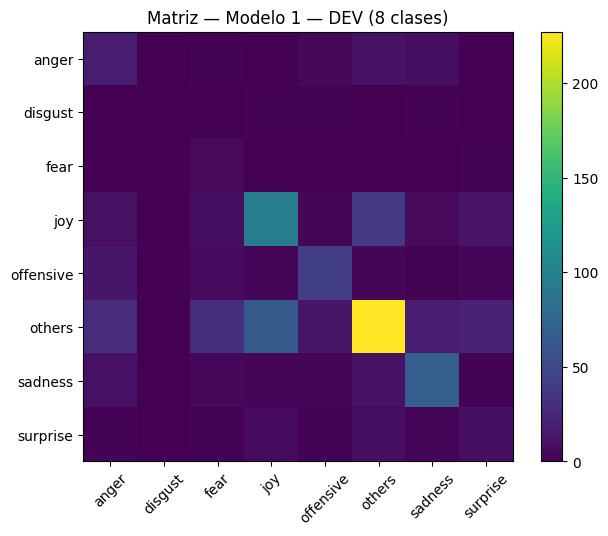


== Modelo 1 — TEST (8 clases) ==


,precision,recall,f1-score,support
anger,0.075000,0.085714,0.080000,140.000000
disgust,0.000000,0.000000,0.000000,31.000000
fear,0.015625,0.105263,0.027211,19.000000
joy,0.237179,0.230530,0.233807,321.000000
offensive,0.576271,0.400000,0.472222,170.000000
others,0.471014,0.442177,0.456140,735.000000
sadness,0.120879,0.122905,0.121884,179.000000
surprise,0.045455,0.049180,0.047244,61.000000
accuracy,0.305556,0.305556,0.305556,0.305556
macro avg,0.192678,0.179471,0.179814,1656.000000


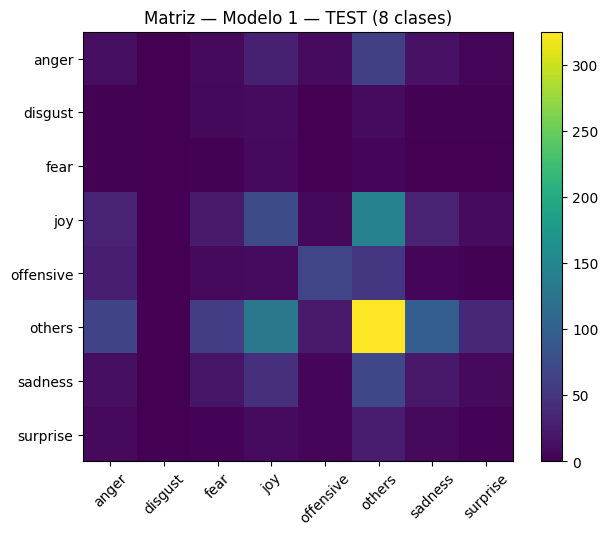


Top eventos — Modelo 1 (TEST)


,event,support,f1_macro,accuracy
0,ChampionsLeague,232,0.177703,0.387931
6,Venezuela,234,0.169141,0.376068
1,GameOfThrones,219,0.157161,0.210046
5,SpainElection,218,0.144298,0.233945
7,WorldBookDay,240,0.142544,0.320833
3,LaLiga,119,0.133049,0.436975
2,GretaThunberg,139,0.110018,0.453237
4,NotreDame,225,0.107000,0.173333
8,nan,30,0.000000,0.000000


In [14]:

# ============================================================
# 5) MODELO 1 — TF-IDF (palabra + carácter) + Logistic Regression
# ============================================================

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Etiquetas y pesos de clase (para desbalance)
y_tr = train["label8"].values
y_dv = dev["label8"].values
y_te = test["label8"].values
labels8 = sorted(np.unique(np.concatenate([y_tr, y_dv, y_te])))

classes = np.unique(y_tr)
class_weight = dict(zip(classes, compute_class_weight("balanced", classes=classes, y=y_tr)))

# Vectorizador de palabras (1–2-gramas) con hashtags explícitos
word_vec = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,
    max_features=50000,
    lowercase=True,
    strip_accents="unicode",
    sublinear_tf=True,
    token_pattern=r'(?u)\b\w+\b|#[\w\-]+'
)

# Vectorizador de caracteres (4–5-gramas), robusto a ruido/elongaciones
char_vec = TfidfVectorizer(
    analyzer="char",
    ngram_range=(4, 5),
    min_df=20,
    sublinear_tf=True
)

# Combinación de espacios de características
feats = ColumnTransformer(
    transformers=[("w", word_vec, "text_clean"), ("c", char_vec, "text_clean")],
    transformer_weights={"w": 1.0, "c": 0.4},
    remainder="drop",
    verbose=False
)

# Clasificador lineal multiclase (saga soporta espacios grandes y L1/L2)
clf = LogisticRegression(
    solver="saga",
    multi_class="multinomial",
    class_weight=class_weight,
    C=3.0,
    max_iter=3000,
    n_jobs=-1
)

# Pipeline completo: featurización + clasificador
pipe = Pipeline([("feats", feats), ("clf", clf)])

# Entrenamiento en train
pipe.fit(train[["text_clean"]], y_tr)

# Utilitario: evaluación y matriz de confusión
def eval_and_plot_from_text(model, df_X, y_true, labels, title):
    y_pred = model.predict(df_X[["text_clean"]])
    rep = classification_report(y_true, y_pred, labels=labels, output_dict=True, zero_division=0)

    # Reporte tabulado
    print(f"\n== {title} ==")
    display(pd.DataFrame(rep).T)

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(6.6, 5.4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Matriz — {title}")
    plt.xticks(range(len(labels)), labels, rotation=45)
    plt.yticks(range(len(labels)), labels)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    return y_pred, rep, cm

# Evaluación en DEV
_, _, _ = eval_and_plot_from_text(pipe, dev,  y_dv, labels8, "Modelo 1 — DEV (8 clases)")

# Evaluación en TEST (guardar predicciones para análisis por evento)
y1_pred_test, rep1, _ = eval_and_plot_from_text(pipe, test, y_te, labels8, "Modelo 1 — TEST (8 clases)")

# Tabla por evento (Top N según F1 macro y soporte)
print("\nTop eventos — Modelo 1 (TEST)")
display(per_event_table(test, y_te, y1_pred_test, labels8).head(15))

##  6) MODELO 2 — spaCy ES (POS/DEP enriquecido) + Regresión Logística

**Objetivo.**  
Explorar un enfoque **lingüísticamente informado** que prescinde de *embeddings* densos y se apoya en rasgos simbólicos derivados del análisis morfosintáctico en español. Este modelo sirve como contraste explicable frente a (i) el baseline léxico TF-IDF y (ii) los modelos con *fine-tuning*.

### Metodología

1. **Análisis lingüístico con spaCy (ES)**
   - Cargamos `es_core_news_md` con `disable=["ner"]` para centrarnos en **POS** (categorías gramaticales) y **dependencias** (relaciones sintácticas) con menor costo computacional.
   - Definimos un conjunto de POS de interés: **NOUN (N), VERB (V), ADJ (J), ADV (R)** por su relevancia semántico-afectiva.

2. **Extracción de rasgos**
   - **B-POS (lemmatizado restringido)**: secuencia textual de **lemmas** pertenecientes a {N, V, J, R}.  
     - Intuición: los **lemmas** reducen variación morfológica y capturan mejor el contenido semántico.
   - **B-DEP+rel (plantillas de relación)**: para cada par **(head, child)** dentro de {N, V, J, R}, construimos **trigramas** del tipo  
     `H:dep:C`, donde `H` y `C` son las clases POS (N/V/J/R) y `dep` es la etiqueta de dependencia (p. ej., `amod`, `nsubj`, `obj`, `advmod`).  
     - Intuición: el **patrón sintáctico** aporta estructura local (quién modifica a quién, con qué tipo de relación), útil para desambiguar matices afectivos.

3. **Vectorización y clasificación**
   - **B-POS** → `TfidfVectorizer` con `ngram_range=(1,2)` y `sublinear_tf=True` (robustez a repeticiones, co-ocurrencias locales de lemmas).  
   - **B-DEP+rel** → `CountVectorizer` con `min_df=5` (BoW discreto; se asume menor densidad y más sparsidad en estas plantillas).  
   - Clasificador: **Regresión Logística Multinomial** (`solver="saga"`, `class_weight='balanced'`, `C=3.0`, `max_iter=3000`).  
     - Razón: lineal, eficiente en espacios dispersos y **explicable** (coeficientes por clase).

4. **Evaluación**
   - **Por clase**: `precision/recall/F1/support` con `classification_report`.  
   - **Matriz de confusión**: inspección de confusiones sistemáticas entre emociones.  
   - **Por evento**: `per_event_table(...)` con **F1 macro** y **accuracy** (filtro `min_support≥5`), para detectar tópicos/eventos donde el modelo funciona mejor/peor.

### Consideraciones computacionales
- El *parsing* sintáctico añade costo (vs TF-IDF puro), pero mantiene **bajo costo de memoria** al trabajar con rasgos dispersos.  
- Desactivar NER reduce latencia sin afectar los rasgos utilizados.

### Limitaciones y valor explicativo
- Los rasgos POS/DEP son **simbólicos**; pueden perder matices semánticos capturados por *embeddings* contextuales.  
- A cambio, ofrecen **interpretabilidad**: es posible inspeccionar **n-gramas de lemmas** o **plantillas sintácticas** con mayor peso por clase (no mostrado aquí por brevedad, pero factible con `clf.coef_`).

> Este segundo modelo permite responder si la **estructura gramatical** aporta señal complementaria a la **superficie léxica**. En resultados típicos, B-POS tiende a acercarse a TF-IDF léxico, y B-DEP+rel puede ayudar en pares de clases con sintaxis distintiva (p. ej., `joy` vs `sadness` con adjetivos/verbos marcadores).

Extrayendo POS/DEP…

== Modelo 2 — B-DEP+rel (DEV) ==


,precision,recall,f1-score,support
anger,0.085714,0.204545,0.120805,44.000000
disgust,0.000000,0.000000,0.000000,5.000000
fear,0.013393,0.428571,0.025974,7.000000
joy,0.344262,0.120690,0.178723,174.000000
offensive,0.205882,0.092105,0.127273,76.000000
others,0.552632,0.207921,0.302158,404.000000
sadness,0.222222,0.115385,0.151899,104.000000
surprise,0.054545,0.200000,0.085714,30.000000
accuracy,0.168246,0.168246,0.168246,0.168246
macro avg,0.184831,0.171152,0.124068,844.000000


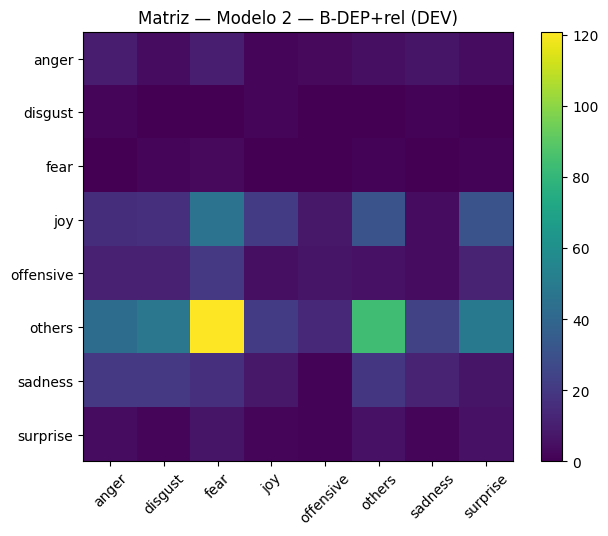


== Modelo 2 — B-POS (TEST) ==


,precision,recall,f1-score,support
anger,0.053763,0.035714,0.042918,140.000000
disgust,0.040816,0.064516,0.050000,31.000000
fear,0.000000,0.000000,0.000000,19.000000
joy,0.223776,0.299065,0.256000,321.000000
offensive,0.466165,0.364706,0.409241,170.000000
others,0.464401,0.390476,0.424242,735.000000
sadness,0.126697,0.156425,0.140000,179.000000
surprise,0.054054,0.065574,0.059259,61.000000
accuracy,0.292271,0.292271,0.292271,0.292271
macro avg,0.178709,0.172060,0.172708,1656.000000


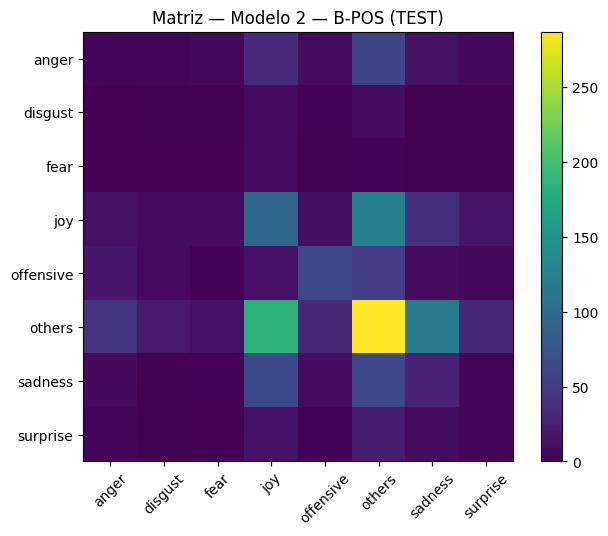


== Modelo 2 — B-DEP+rel (TEST) ==


,precision,recall,f1-score,support
anger,0.083916,0.085714,0.084806,140.0000
disgust,0.023148,0.161290,0.040486,31.0000
fear,0.014218,0.315789,0.027211,19.0000
joy,0.235294,0.087227,0.127273,321.0000
offensive,0.103896,0.047059,0.064777,170.0000
others,0.450292,0.209524,0.285980,735.0000
sadness,0.090090,0.055866,0.068966,179.0000
surprise,0.044248,0.163934,0.069686,61.0000
accuracy,0.140700,0.140700,0.140700,0.1407
macro avg,0.130638,0.140801,0.096148,1656.0000


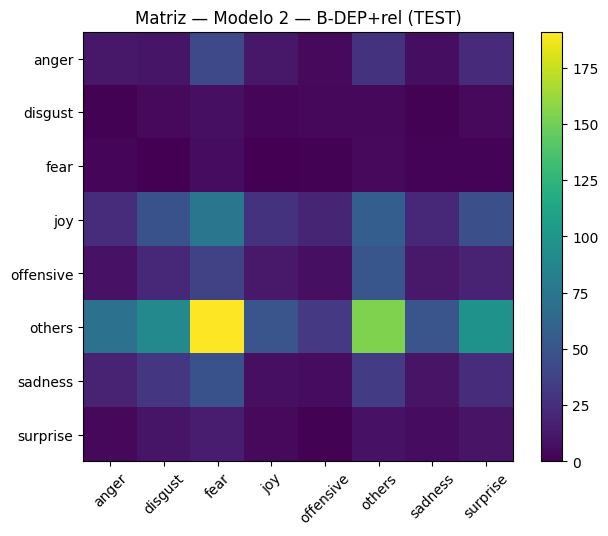


Top eventos — Modelo 2 (B-POS, TEST)


,event,support,f1_macro,accuracy
6,Venezuela,234,0.195287,0.380342
0,ChampionsLeague,232,0.184054,0.318966
1,GameOfThrones,219,0.168150,0.246575
7,WorldBookDay,240,0.160030,0.270833
5,SpainElection,218,0.140990,0.261468
3,LaLiga,119,0.124767,0.378151
2,GretaThunberg,139,0.118962,0.410072
4,NotreDame,225,0.096791,0.191111
8,nan,30,0.000000,0.000000



Top eventos — Modelo 2 (B-DEP+rel, TEST)


,event,support,f1_macro,accuracy
2,GretaThunberg,139,0.131092,0.187050
1,GameOfThrones,219,0.125478,0.168950
0,ChampionsLeague,232,0.122086,0.181034
3,LaLiga,119,0.102061,0.184874
5,SpainElection,218,0.080740,0.133028
4,NotreDame,225,0.078608,0.124444
6,Venezuela,234,0.077027,0.102564
7,WorldBookDay,240,0.065738,0.104167
8,nan,30,0.000000,0.000000


In [16]:
# ============================================================
# 5) MODELO 2 — spaCy ES (POS/DEP enriquecido) + Logistic Regression
# ============================================================

# Carga del pipeline español de spaCy; NER desactivado para ahorrar cómputo
nlp = spacy.load("es_core_news_md", disable=["ner"])

# POS objetivo (mapeo a etiquetas compactas)
POS_KEEP = {"NOUN":"N", "VERB":"V", "ADJ":"J", "ADV":"R"}

def extract_pos_dep_enhanced(texts, batch_size=512, n_process=2):
    """
    Genera dos vistas de rasgos a partir de spaCy:
    - POS_txt: "lemma lemma ..." con solo NOUN/VERB/ADJ/ADV (lemmas limpios)
    - DEP2_txt: "H:dep:C" donde H,C ∈ {N,V,J,R} y 'dep' es la etiqueta de dependencia

    'n_process' puede aprovechar multinúcleo; ajustar según entorno.
    """
    pos_strs, dep2_strs = [], []

    for doc in nlp.pipe(texts, batch_size=batch_size, n_process=n_process):
        # --- Vista B-POS (lemmatizada y filtrada por POS) ---
        lem = [
            t.lemma_.strip().lower()
            for t in doc
            if t.pos_ in POS_KEEP and not t.is_space and t.lemma_
        ]
        pos_strs.append(" ".join(lem) if lem else "")

        # --- Vista B-DEP+rel (plantillas Head:dep:Child) ---
        feats = []
        for h in doc:
            hp = POS_KEEP.get(h.pos_, None)
            if not hp:
                continue
            for c in h.children:
                cp = POS_KEEP.get(c.pos_, None)
                if not cp:
                    continue
                dep = c.dep_
                if dep:
                    feats.append(f"{hp}:{dep}:{cp}")
        dep2_strs.append(" ".join(feats) if feats else "")

    return pos_strs, dep2_strs

print("Extrayendo POS/DEP…")
tr_pos, tr_dep2 = extract_pos_dep_enhanced(train["text_clean"].tolist())
dv_pos, dv_dep2 = extract_pos_dep_enhanced(dev["text_clean"].tolist())
te_pos, te_dep2 = extract_pos_dep_enhanced(test["text_clean"].tolist())

# Anexamos las vistas al dataframe
train = train.assign(POS_txt=tr_pos, DEP2_txt=tr_dep2)
dev   = dev.assign(POS_txt=dv_pos, DEP2_txt=dv_dep2)
test  = test.assign(POS_txt=te_pos, DEP2_txt=te_dep2)

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# --- Vectorizador para B-POS: TF-IDF (1–2-gramas) ---
vec_pos = TfidfVectorizer(
    lowercase=False,
    min_df=1,
    ngram_range=(1,2),
    max_features=60000,
    sublinear_tf=True
)
Xtr_pos = vec_pos.fit_transform(train["POS_txt"])
Xd_pos  = vec_pos.transform(dev["POS_txt"])
Xt_pos  = vec_pos.transform(test["POS_txt"])

# --- Vectorizador para B-DEP+rel: BoW con min_df=5 ---
vec_dep2 = CountVectorizer(
    lowercase=False,
    min_df=5
)
Xtr_dep2 = vec_dep2.fit_transform(train["DEP2_txt"])
Xd_dep2  = vec_dep2.transform(dev["DEP2_txt"])
Xt_dep2  = vec_dep2.transform(test["DEP2_txt"])

# --- Clasificadores lineales (multinomial) con balance de clases ---
clf_pos  = LogisticRegression(
    max_iter=3000, class_weight='balanced', solver="saga",
    multi_class="multinomial", C=3.0
).fit(Xtr_pos, y_tr)

clf_dep2 = LogisticRegression(
    max_iter=3000, class_weight='balanced', solver="saga",
    multi_class="multinomial", C=3.0
).fit(Xtr_dep2, y_tr)

# --- Utilitario de evaluación genérico (tablas + matriz de confusión) ---
def eval_and_plot_generic(model, X, y_true, labels, title):
    y_pred = model.predict(X)
    rep = classification_report(
        y_true, y_pred, labels=labels, output_dict=True, zero_division=0
    )

    print(f"\n== {title} ==")
    display(pd.DataFrame(rep).T)

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(6.6,5.4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Matriz — {title}")
    plt.xticks(range(len(labels)), labels, rotation=45)
    plt.yticks(range(len(labels)), labels)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    return y_pred, rep, cm

# # Evaluación en DEV
# _, _, _ = eval_and_plot_generic(clf_pos,  Xd_pos,  y_dv, labels8, "Modelo 2 — B-POS (DEV)")
_, _, _ = eval_and_plot_generic(clf_dep2, Xd_dep2, y_dv, labels8, "Modelo 2 — B-DEP+rel (DEV)")

# --- Evaluación en TEST ---
y2_pos_test, rep2a, _ = eval_and_plot_generic(clf_pos,  Xt_pos,  y_te, labels8, "Modelo 2 — B-POS (TEST)")
y2_dep_test, rep2b, _ = eval_and_plot_generic(clf_dep2, Xt_dep2, y_te, labels8, "Modelo 2 — B-DEP+rel (TEST)")

# --- Análisis por evento ---
print("\nTop eventos — Modelo 2 (B-POS, TEST)")
display(per_event_table(test, y_te, y2_pos_test, labels8).head(15))

print("\nTop eventos — Modelo 2 (B-DEP+rel, TEST)")
display(per_event_table(test, y_te, y2_dep_test, labels8).head(15))

##  7) MODELO 3 — Fine-tuning con TF/Keras (BETO) sin `Trainer`

**Objetivo.**  
Evaluar un enfoque **contextual** basado en *transformers* para clasificación de emociones en español, realizando **fine-tuning** extremo a extremo con **TensorFlow/Keras** (sin `transformers.Trainer`). Esto nos permite un control explícito del *pipeline* y evita incompatibilidades reportadas con ciertas combinaciones de versiones.

### Diseño del modelo y tokenización
- **Backbone**: `dccuchile/bert-base-spanish-wwm-uncased` (BETO), un BERT entrenado en corpus de español, con **pesos nativos de TensorFlow**, lo que facilita su uso con `TFAutoModelForSequenceClassification`.
- **Cabeza de clasificación**: capa densa sobre el *[CLS]* (logits) con `num_labels = 8` (`label8`).
- **Tokenización**: `AutoTokenizer` con `max_length=128` y **padding estático** (`max_length`) para acelerar el *input pipeline* en GPU.

### Protocolo de entrenamiento (Keras)
- **`tf.data`**: construcción de `Dataset` para `train/dev/test`, con *prefetching* y *batching*; `shuffle` solo para *train*.
- **Optimización**: `Adam(2e-5)` (tasa estándar en *fine-tuning* BERT).
- **Pérdida**: `SparseCategoricalCrossentropy(from_logits=True)` (las salidas del modelo son logits).
- **Métricas**: `accuracy` durante el entrenamiento/validación.
- **Clase desbalanceada**: `class_weight` (computado desde *train*) para reponderar la pérdida por clase.
- **Regularización temprana**: `EarlyStopping` monitorizando `val_loss` con `patience=1` y restauración de los mejores pesos.

### Evaluación y reporte
1. **DEV** y **TEST**:  
   - `classification_report` por clase (precision, recall, F1, support).  
   - **Matriz de confusión** con orden de etiquetas fijado para comparabilidad.
2. **Análisis por evento**:  
   - F1 macro y accuracy por `event` (descarta eventos con `support < 5`).  
   - Tabla ordenada por `f1_macro` y `support` (Top-15).

### Hiperparámetros y decisiones
- `MAX_LEN=128` (compromiso entre cobertura y costo; tweets suelen ser cortos).
- `BATCH=16` (estable para memoria de GPU en Colab T4/P100; ajustar si OOM).
- `EPOCHS=3` +

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
358/358 [==============================] - 213s 454ms/step - loss: 1.6962 - accuracy: 0.3839 - val_loss: 1.2625 - val_accuracy: 0.5581
Epoch 2/3
358/358 [==============================] - 155s 434ms/step - loss: 1.1320 - accuracy: 0.5679 - val_loss: 1.1959 - val_accuracy: 0.5509
Epoch 3/3
358/358 [==============================] - 155s 432ms/step - loss: 0.7791 - accuracy: 0.6490 - val_loss: 1.1391 - val_accuracy: 0.6043

== dccuchile/bert-base-spanish-wwm-uncased — DEV (8 clases) ==


,precision,recall,f1-score,support
anger,0.307692,0.363636,0.333333,44.000000
disgust,0.036145,0.600000,0.068182,5.000000
fear,0.333333,0.714286,0.454545,7.000000
joy,0.619048,0.672414,0.644628,174.000000
offensive,0.820000,0.539474,0.650794,76.000000
others,0.799342,0.601485,0.686441,404.000000
sadness,0.816092,0.682692,0.743455,104.000000
surprise,0.218750,0.466667,0.297872,30.000000
accuracy,0.604265,0.604265,0.604265,0.604265
macro avg,0.493800,0.580082,0.484906,844.000000


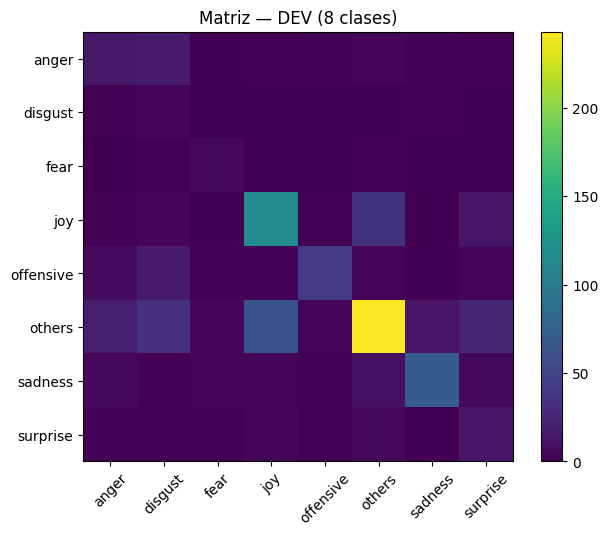

Top eventos — DEV (8 clases)


,event,support,f1_macro,accuracy
5,SpainElection,119,0.496865,0.563025
3,LaLiga,44,0.465259,0.750000
4,NotreDame,123,0.395918,0.674797
6,Venezuela,113,0.368803,0.460177
0,ChampionsLeague,126,0.344079,0.626984
1,GameOfThrones,124,0.331241,0.435484
7,WorldBookDay,139,0.247025,0.719424
2,GretaThunberg,56,0.225026,0.750000



== dccuchile/bert-base-spanish-wwm-uncased — TEST (8 clases) ==


,precision,recall,f1-score,support
anger,0.084112,0.064286,0.072874,140.000000
disgust,0.018519,0.096774,0.031088,31.000000
fear,0.000000,0.000000,0.000000,19.000000
joy,0.232759,0.252336,0.242152,321.000000
offensive,0.783133,0.382353,0.513834,170.000000
others,0.485893,0.421769,0.451566,735.000000
sadness,0.146067,0.145251,0.145658,179.000000
surprise,0.045045,0.081967,0.058140,61.000000
accuracy,0.301329,0.301329,0.301329,0.301329
macro avg,0.224441,0.180592,0.189414,1656.000000


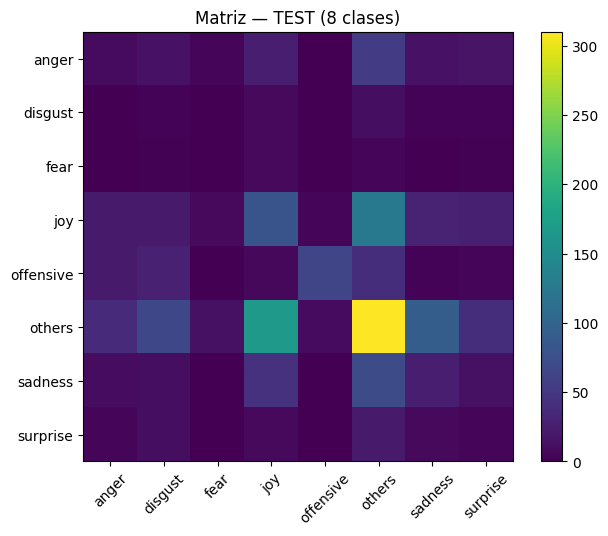

Top eventos — TEST (8 clases)


,event,support,f1_macro,accuracy
0,ChampionsLeague,232,0.209051,0.370690
1,GameOfThrones,219,0.200383,0.301370
2,GretaThunberg,139,0.183082,0.402878
7,WorldBookDay,240,0.182906,0.283333
6,Venezuela,234,0.178154,0.269231
3,LaLiga,119,0.176077,0.445378
4,NotreDame,225,0.156943,0.226667
5,SpainElection,218,0.143297,0.256881
8,nan,30,0.000000,0.000000


In [17]:

# ============================================================
# 7) MODELO 3 (sin Trainer): Fine-tuning con TF/Keras
#  - Usa TFAutoModelForSequenceClassification (BETO)
#  - Entrena con tf.keras (Adam) + EarlyStopping
#  - Reporta métricas por clase, matriz de confusión y por evento
#  - Sin transformers.Trainer (control explícito del pipeline)
# Requisitos previos EN MEMORIA: train, dev, test con 'tweet','event','label8'
# ============================================================

import os, random, warnings
import numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED); np.random.seed(SEED)

# --- Comprobaciones mínimas de esquema ---
for name, df in [("train", train), ("dev", dev), ("test", test)]:
    assert all(c in df.columns for c in ["tweet","event","label8"]), f"Falta columna en {name}"

# --- Imports (sin Trainer) ---
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# --- Etiquetas y mapeos ---
labels = sorted(train["label8"].unique().tolist())
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}

# --- Backbone BETO (pesos nativos TF) + tokenizer ---
MODEL_NAME = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

# --- TF data: tokenización → tf.data.Dataset ---
MAX_LEN = 128
BATCH   = 16

def make_ds(df, shuffle=False):
    enc = tokenizer(
        df["tweet"].tolist(),               # (opcional) cambiar a df["text_clean"] si se desea usar el texto preprocesado
        truncation=True, padding="max_length", max_length=MAX_LEN,
        return_tensors="tf"
    )
    y = np.array([label2id[x] for x in df["label8"]], dtype="int32")
    ds = tf.data.Dataset.from_tensor_slices((dict(enc), y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), seed=SEED, reshuffle_each_iteration=True)
    return ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)

ds_train = make_ds(train, shuffle=True)
ds_val   = make_ds(dev,   shuffle=False)
ds_test  = make_ds(test,  shuffle=False)

# --- Reponderación por clase (desbalance) ---
y_tr_ids = np.array([label2id[x] for x in train["label8"]], dtype="int32")
cw = compute_class_weight(class_weight="balanced", classes=np.arange(len(labels)), y=y_tr_ids)
class_weight_keras = {i:w for i,w in enumerate(cw)}

# --- Modelo TF + Keras (clasificación) ---
model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=len(labels), id2label=id2label, label2id=label2id
)

# Optimizador y pérdida (desde logits)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss      = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

# EarlyStopping para evitar sobreajuste y restaurar mejores pesos
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=1, restore_best_weights=True)]

# --- Entrenamiento ---
EPOCHS = 3
hist = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    class_weight=class_weight_keras,
    callbacks=callbacks,
    verbose=1
)

# --- Evaluación: DEV y TEST (por clase / matriz / por evento) ---
def eval_split(ds_split, df_split, split_name):
    out = model.predict(ds_split, verbose=0)
    logits = out.logits if hasattr(out, "logits") else out[0]
    y_pred = np.argmax(logits, axis=-1)
    y_true = np.array([label2id[x] for x in df_split["label8"]], dtype="int32")

    # a etiquetas legibles
    y_true_l = [id2label[int(i)] for i in y_true]
    y_pred_l = [id2label[int(i)] for i in y_pred]

    # Reporte por clase
    rep = classification_report(y_true_l, y_pred_l, labels=labels, output_dict=True, zero_division=0)
    print(f"\n== {MODEL_NAME} — {split_name} ==")
    display(pd.DataFrame(rep).T)

    # Matriz de confusión
    cm = confusion_matrix(y_true_l, y_pred_l, labels=labels)
    plt.figure(figsize=(6.6,5.4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Matriz — {split_name}")
    plt.xticks(range(len(labels)), labels, rotation=45)
    plt.yticks(range(len(labels)), labels)
    plt.colorbar()
    plt.tight_layout(); plt.show()

    # Análisis por evento (F1 macro + accuracy)
    tmp = df_split.copy()
    tmp["true"] = y_true_l
    tmp["pred"] = y_pred_l
    rows = []
    for ev, g in tmp.groupby("event"):
        if len(g) < 5:  # ignora eventos con muy poco soporte
            continue
        r = classification_report(g["true"], g["pred"], labels=labels, output_dict=True, zero_division=0)
        rows.append({
            "event": ev,
            "support": len(g),
            "f1_macro": r["macro avg"]["f1-score"],
            "accuracy": (g["true"].to_numpy() == g["pred"].to_numpy()).mean()
        })
    if rows:
        print(f"Top eventos — {split_name}")
        display(pd.DataFrame(rows).sort_values(["f1_macro","support"], ascending=[False,False]).head(15))

# Ejecuta evaluación
eval_split(ds_val,  dev,  "DEV (8 clases)")
eval_split(ds_test, test, "TEST (8 clases)")